In [110]:
# Load the modules
import os, sys, logging
import boto3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import interp1d
from scipy.signal import butter, sosfiltfilt
# Set the universal font type to times new roman
plt.rcParams["font.family"] = "Times New Roman"

## This notebook shows how to access the Ridgecrest DAS data on AWS and also provide some basic processing and visualization of the data.
### It was modified from "yinjiuxun" git tutorial
Notebook tutorial for pulling the DAS data https://github.com/yinjiuxun/DAS_aws_Ridgecrest/blob/master/access_aws_data.ipynb

### Setup the AWS SCEDC bucket information
Video tutorial for setting AWS IAM accout https://www.youtube.com/watch?v=tW3HoYRnABs <br>


In [2]:
# session = boto3.Session(
#     aws_access_key_id=settings.AWS_SERVER_PUBLIC_KEY,
#     aws_secret_access_key=settings.AWS_SERVER_SECRET_KEY,
# )

In [3]:
boto3.set_stream_logger('boto3', logging.INFO)
s3 = boto3.resource('s3')
bucket = s3.Bucket('scedc-pds')
s3.meta.client.head_bucket(Bucket='scedc-pds')

{'ResponseMetadata': {'RequestId': '60ED745JFRJ0YR5G',
  'HostId': 'CvvBhJQsQDDK8wEioAiH1WW+IIYPdiceUBqtXps2ArGLJbSn0sCh6eDa0I3bUf9YCFUP4VCqpHc=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'CvvBhJQsQDDK8wEioAiH1WW+IIYPdiceUBqtXps2ArGLJbSn0sCh6eDa0I3bUf9YCFUP4VCqpHc=',
   'x-amz-request-id': '60ED745JFRJ0YR5G',
   'date': 'Fri, 07 Apr 2023 16:49:53 GMT',
   'x-amz-bucket-region': 'us-west-2',
   'x-amz-access-point-alias': 'false',
   'content-type': 'application/xml',
   'server': 'AmazonS3'},
  'RetryAttempts': 1}}

### One month (2020/06/23 - 2020/07/29, ~4TB) of Ridgecrest DAS hourly data (250 Hz sampling rate) are currently on AWS.
### We will look at the file 2020062417.segy, which contains an M5.8 events (ID: 39493944; 2020/06/24T17:40:49, lat = 36.4468, lon= -117.9752, dep = 4.66km)

In [38]:
# The key of the M5.8 earthquake
# I first downloaded the 17:00 data with 20200624"17", then changed the next 2 lines to 18
keys = ['Ridgecrest_DAS/SEG-Y/hourly/2020062418.segy']
file_names = ['/Ridgecrest_DAS/SEG-Y/hourly/2020062418.segy']

# A CSV file including the DAS channel information
das_channel_key = 'Ridgecrest_DAS/das_info.csv'
das_channel_file_names = '/Ridgecrest_DAS/das_info.csv'

### Option 2. Download the DAS file to the local machine
Each file is 4.5 gb large

In [39]:
# Make a directory to store the downloaded DAS data
download_dir = 'das_data' 
# download_dir = '/kuafu/yinjx/AWS_Ridgecrest/download_test/'
# Make the directory to put the downloaded data
data_dir = download_dir

print(data_dir+'/Ridgecrest_DAS')
try:
    os.mkdir(data_dir+'/Ridgecrest_DAS')
except OSError:
    print ("*Creation of the directory %s failed" % data_dir)
else:
    print ("Successfully created the directory %s " % data_dir)
print(data_dir+'/Ridgecrest_DAS')

try:
    os.mkdir(data_dir+'/Ridgecrest_DAS/SEG-Y')
except OSError:
    print ("*Creation of the directory %s failed" % data_dir)
else:
    print ("Successfully created the directory %s " % data_dir)
print(data_dir)

try:
    os.mkdir(data_dir+'/Ridgecrest_DAS/SEG-Y/hourly')
except OSError:
    print ("*Creation of the directory %s failed" % data_dir)
else:
    print ("Successfully created the directory %s " % data_dir)
    
print('Downloaded data will be stored here:',data_dir)


# Download the DAS channel info file
bucket.download_file(das_channel_key,data_dir + '/Ridgecrest_DAS/das_info.csv')


# Download the DAS data
for index in np.arange(len(keys)):
    key=keys[index]; file_name=file_names[index]
    file_path = data_dir+file_name
    bucket.download_file(key,file_path)

das_data/Ridgecrest_DAS
*Creation of the directory das_data failed
das_data/Ridgecrest_DAS
*Creation of the directory das_data failed
das_data
*Creation of the directory das_data failed
Downloaded data will be stored here: das_data


### Load the downloaded data and visualize (example is following the Option 2 on local machine, but can also be easliy modified for AWS)
Functions used to load and plot the hourly DAS data

In [66]:
# Function to load the DAS data
def read_PASSCAL_segy(infile, nTraces=1250, nSample=900000, TraceOff=0):
    """Function to read PASSCAL segy raw data
    For Ridgecrest data, there are 1250 channels in total,
    Sampling rate is 250 Hz so for one hour data: 250 * 3600 samples
    """
    fs = nSample/ 3600 # sampling rate
    data = np.zeros((nTraces, nSample), dtype=np.float32)
    gzFile = False
    if infile.split(".")[-1] == "segy":
        fid = open(infile, 'rb')
    elif infile.split(".")[-1] == "gz":
        gzFile = True
        fid = gzip.open(infile, 'rb')
    fid.seek(3600)
    # Skipping traces if necessary
    fid.seek(TraceOff*(240+nSample*4),1)
    # Looping over traces
    for ii in range(nTraces):
        fid.seek(240, 1)
        if gzFile:
            # np.fromfile does not work on gzip file
            BinDataBuffer = fid.read(nSample*4) # read binary bytes from file
            data[ii, :] = struct.unpack_from(">"+('f')*nSample, BinDataBuffer)
        else:
            data[ii, :] = np.fromfile(fid, dtype=np.float32, count=nSample)
    fid.close()

    # Convert the phase-shift to strain (in nanostrain)
    Ridgecrest_conversion_factor = 1550.12 / (0.78 * 4 * np.pi * 1.46 * 8)
    data = data * Ridgecrest_conversion_factor

    das_time = np.arange(0, data.shape[1]) * 1 / fs

    return data, das_time

# downsample functions: downsample the DAS data to a given frequency fd
def donwsample_das(data, das_time, fd=100):
    """
    Down sample das data to fd Hz
    data, das_time_downsampled = donwsample_das(data, das_time, fd=100)
    This function is really slow for 2 hours of data and can be improved
    """
    das_dt_ds = 1/fd
    das_time_downsampled = np.arange(0, das_time[-1], das_dt_ds)

    downsample_f = interp1d(das_time, data, axis=1, bounds_error=False, fill_value=0)
    data = downsample_f(das_time_downsampled)
    return data, das_time_downsampled

# plot the DAS data
def show_data(data, das_time, pclip=99.5):
    fig, ax1 = plt.subplots(figsize=(8,4))
    clipVal = np.percentile(np.absolute(data), pclip)
    ax1.imshow(data.T, 
                extent=[0, data.shape[0], das_time[-1], das_time[0]],
                aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))

    ax1.set_xlabel("Channel number")
    ax1.set_ylabel("Time [s]")
    ax1.grid()
    return fig, ax1

### First load the information about the DAS array

In [12]:
# Load the DAS info file, a Pandas modules can greatly simply this step
temp = np.genfromtxt(data_dir + '/Ridgecrest_DAS/das_info.csv', delimiter=',', skip_header=1)
channel_index = temp[:, 0].astype('int') # Index of good channels
channel_lat = temp[:, 1] # channel latitude
channel_lon = temp[:, 2] # channel longitude

### Then load the downloaded DAS data, data unit is nano strain
I merged the data for 2 hours from 17:00 - 18:59:59

In [59]:
strain1, das_time1 = read_PASSCAL_segy('das_data/Ridgecrest_DAS/SEG-Y/hourly/2020062417.segy') 
strain2, das_time2 = read_PASSCAL_segy(file_path) # Data shape: n_channel x n_samples, data unit is nano strain
# Merge the 2 time and  arrays
das_time = np.concatenate((das_time1,das_time1.max()+das_time2), axis=0)
strain = np.hstack((strain1,strain2))
# Extract the sampling rate
dt = das_time[1] - das_time[0]
# Data is in [num_channels, num_time_samples]
print(strain.shape)

(1250, 1800000)


# Downsample the data from 250 Hz to 100 Hz

In [60]:
# Downsample the data
strain, das_time = donwsample_das(strain, das_time, fd=100)
print(strain.shape)

(1250, 720000)


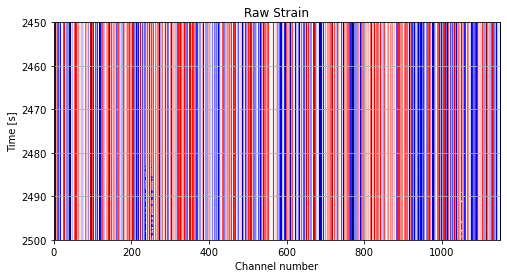

In [162]:
# Show how the raw data looks 
fig, ax1 = show_data(strain[channel_index, ::20], das_time, pclip=98)
ax1.set_ylim(2500, 2450)
ax1.set_title('Raw Strain')
plt.show()

### High pass filter is often needed to remove the low frequency signals in the DAS data to show earthquake signals

In [62]:
sos = butter(4, 0.5*2*dt, output='sos', btype='high')
strain_filt = sosfiltfilt(sos, strain, axis=1)
print(f'The sampling period is {dt} and sampling frequency is {1/dt}')

The sampling period is 0.004 and sampling frequency is 250.0


### Plot the HP filtered data

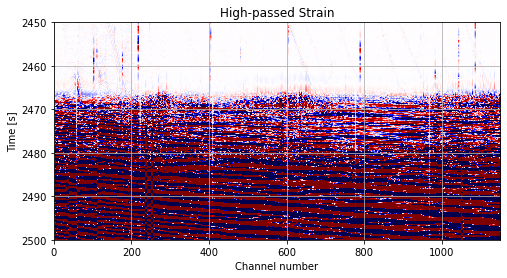

In [163]:
# strain_filt[channel_index, ::20] - The ::20 decimates the time axis every 20 points e.g. 3600/20 = 180
fig, ax2 = show_data(strain_filt[channel_index, ::20], das_time, pclip=98)
ax2.set_ylim(2500, 2450)
ax2.set_title('High-passed Strain')
plt.show()

### Directly convert the raw strain to strain rate is another way to show the earthquake signal

In [64]:
strain_rate = np.diff(strain, axis=1)
strain_rate_time = das_time[:-1] + dt/2

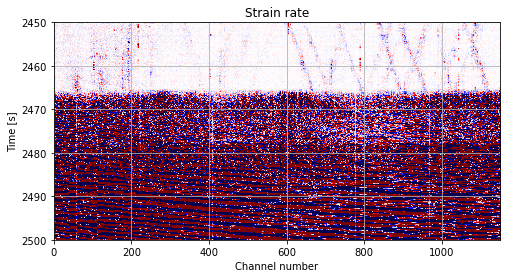

In [164]:
fig, ax3 = show_data(strain_rate[channel_index, ::20], strain_rate_time, pclip=98)
ax3.set_ylim(2500, 2450)
ax3.set_title('Strain rate')
plt.show()

### Save the data

In [120]:
# Create numpy array of datetimes
#plt_time = np.datetime64('2020-06-24 17:00:00') + strain_rate_time.astype(np.timedelta64)
# Save the file to a numpy zip file
# np.savez('das_data/Ridgecrest_DAS/SEG-Y/hourly/two_days.npz',strain=strain_rate,time=plt_time,fs=100)

### Convert the time array to compatible python datetime formats

In [134]:
# Create numpy array of datetimes
plt_time = np.datetime64('2020-06-24 17:00:00') + strain_rate_time.astype(np.timedelta64)
# Convert from npdatetime64 to datetime.datetime
plt_time = plt_time.tolist()
# Convert to matplotlib time
y_lims = mdates.date2num(plt_time)

### Plot the 3 seismic events

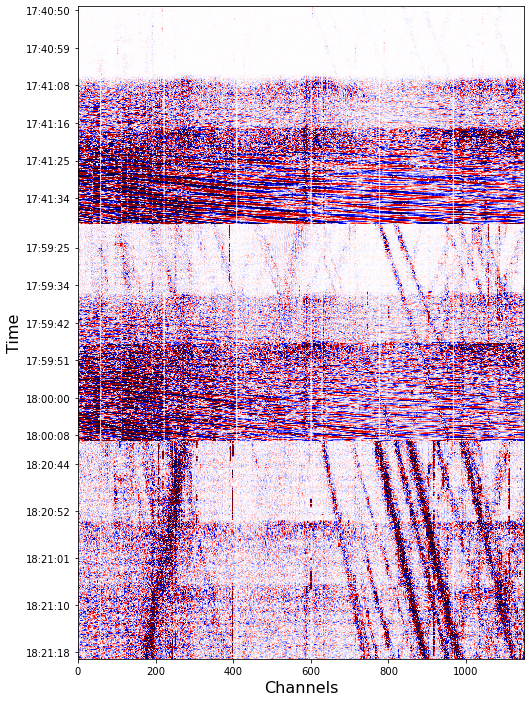

In [189]:
fig,ax_a = plt.subplots(3,1,figsize=(8,12),gridspec_kw={'hspace':0.0})

cmap = plt.get_cmap('seismic')
ax_a[1].set_ylabel('Time',size=16),ax_a[2].set_xlabel('Channels',size=16)
ax_a[0].set_xticks([]),ax_a[1].set_xticks([])
ax_a[0].spines['bottom'].set_visible(False),ax_a[1].spines['top'].set_visible(False)
ax_a[1].spines['bottom'].set_visible(False),ax_a[2].spines['top'].set_visible(False)

# Event 1 - Mw 5.8
pclip,lims = 90,(245000,250000)
data = strain_rate[channel_index, lims[0]:lims[1]:20]
clipVal = np.percentile(np.absolute(data), pclip)
ax_a[0].imshow(data.T, extent=[0, data.shape[0], y_lims[lims[1]], y_lims[lims[0]]],
               aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=cmap)
ax_a[0].yaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# Event 2 - Mw 4.6
pclip,lims = 90,(356000,361000)
data = strain_rate[channel_index, lims[0]:lims[1]:20]
clipVal = np.percentile(np.absolute(data), pclip)
ax_a[1].imshow(data.T, extent=[0, data.shape[0], y_lims[lims[1]], y_lims[lims[0]]],
               aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=cmap)
ax_a[1].yaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# Event 3 - Mw 3.8
pclip,lims = 90,(484000,488000)
data = strain_rate[channel_index, lims[0]:lims[1]:20]
clipVal = np.percentile(np.absolute(data), pclip)
ax_a[2].imshow(data.T, extent=[0, data.shape[0], y_lims[lims[1]], y_lims[lims[0]]],
               aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=cmap)
ax_a[2].yaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# plt.savefig('das_data/Ridgecrest_DAS/SEG-Y/hourly/three_events.png',dpi=200,bbox_inches='tight')
plt.show()

### Plot individual channels

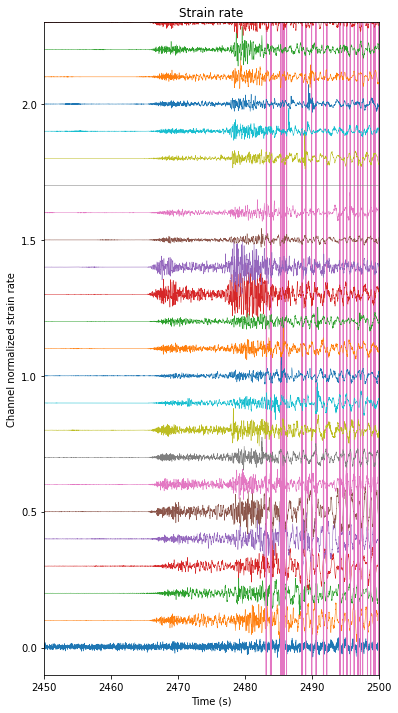

In [168]:
# Show data in time series
clipVal = np.percentile(np.absolute(strain_rate_time), 98)
strain_rate1 = strain_rate/clipVal
fig, ax = plt.subplots(figsize=(6, 12))
for i in range(0, 1250, 50):
    ax.plot(strain_rate_time, strain_rate1[i, :] + i/500, linewidth=0.5)

ax.set_ylim(-0.1, 2.3)
ax.set_xlim(2450, 2500)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Channel normalized strain rate')
ax.set_title('Strain rate')
plt.show()

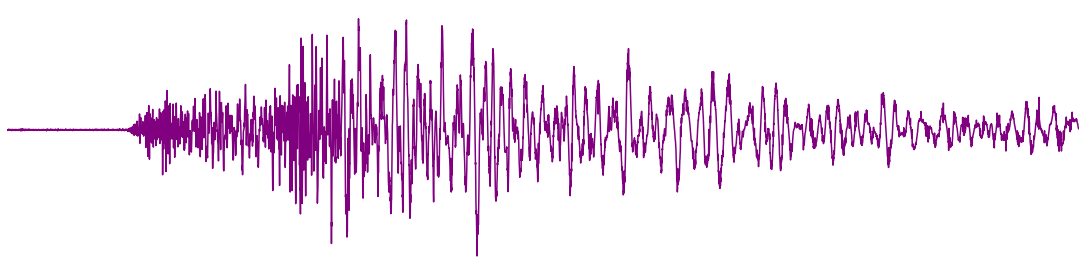

In [190]:
plt.figure(figsize=(19.20,4.80))
plt.plot(strain_rate_time, strain_rate1[50, :], linewidth=1.5, c='purple')
plt.xticks([]),plt.yticks([]),plt.xlim(2455, 2550)
for s in ['top','bottom','right','left']:
    plt.gca().spines[s].set_visible(False)
# plt.savefig('das_data/Ridgecrest_DAS/SEG-Y/hourly/single_trace.png',dpi=200,bbox_inches='tight')
plt.show()